In [2]:
import pandas as pd
pd.options.display.max_columns=200
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings('ignore')
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,\
      mean_squared_log_error, mean_absolute_error, make_scorer, r2_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from scipy.stats import skew
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
import shap
from xgboost import XGBRegressor

In [3]:
data = pd.read_csv('data.csv')

In [4]:
data.set_index('OSEBuildingID', inplace = True)

In [5]:
cols = ['Age','PropertyGFATotal',
       'SiteEUI(kBtu/sf)',
       'LargestPropertyUseTypeGFA','ENERGYSTARScore', 'TotalGHGEmissions']

Age
0.29753360879193896


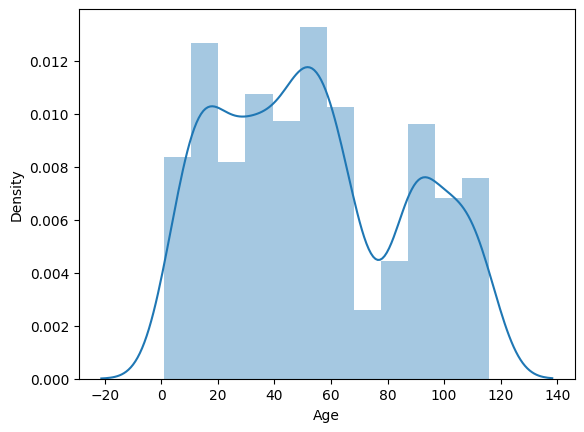

PropertyGFATotal
19.037917545145827


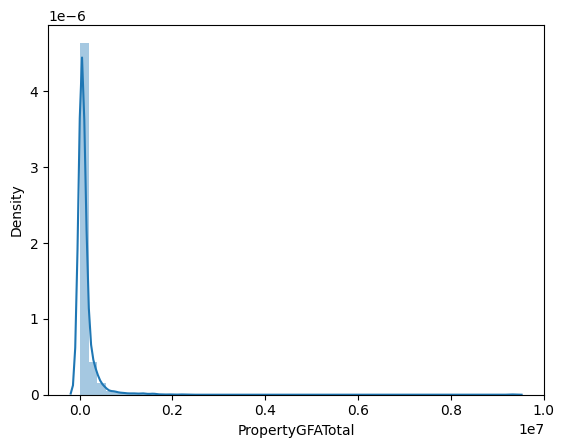

SiteEUI(kBtu/sf)
3.7670004531738477


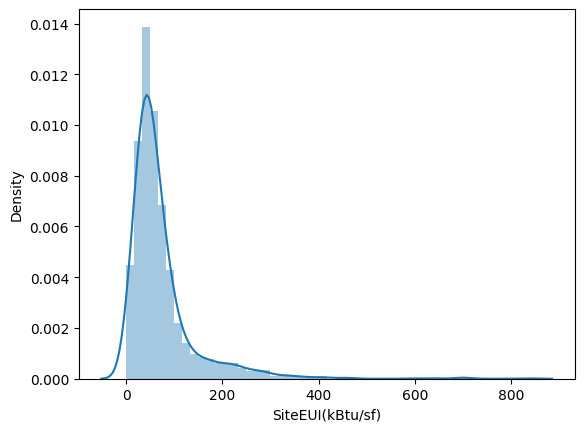

LargestPropertyUseTypeGFA
23.175161728669494


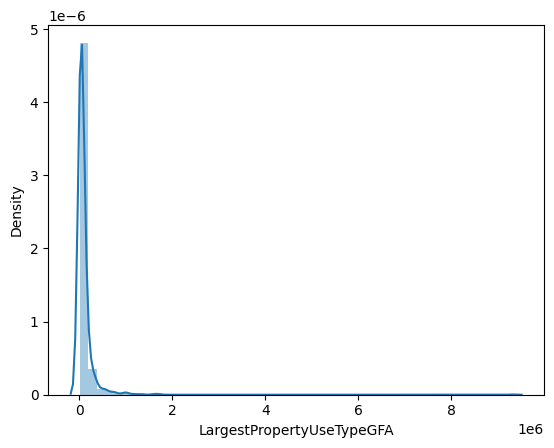

ENERGYSTARScore
0.07727154779048637


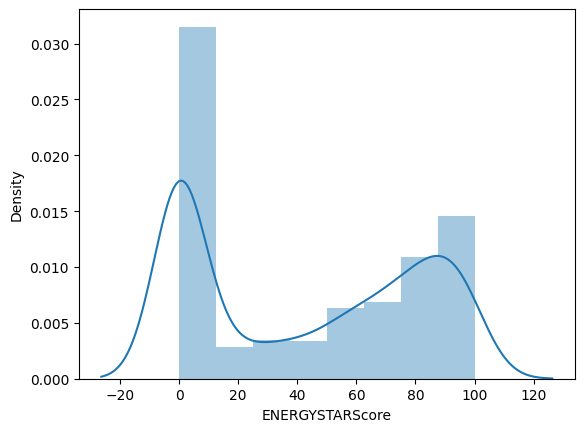

TotalGHGEmissions
14.130616835139792


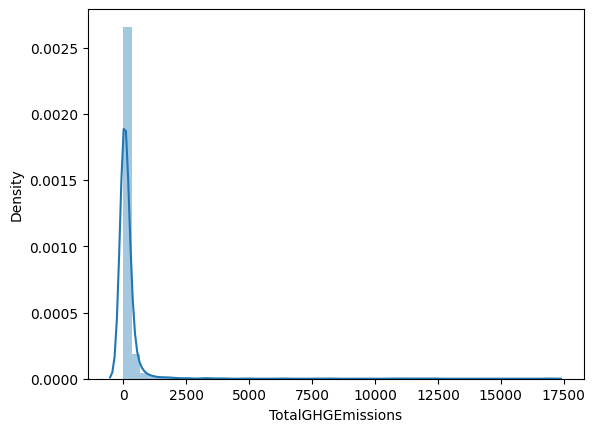

In [6]:
for col in cols:
      print(col)
      print(skew(data[col]))

      plt.figure()
      sns.distplot(data[col])
      plt.show()

<AxesSubplot: >

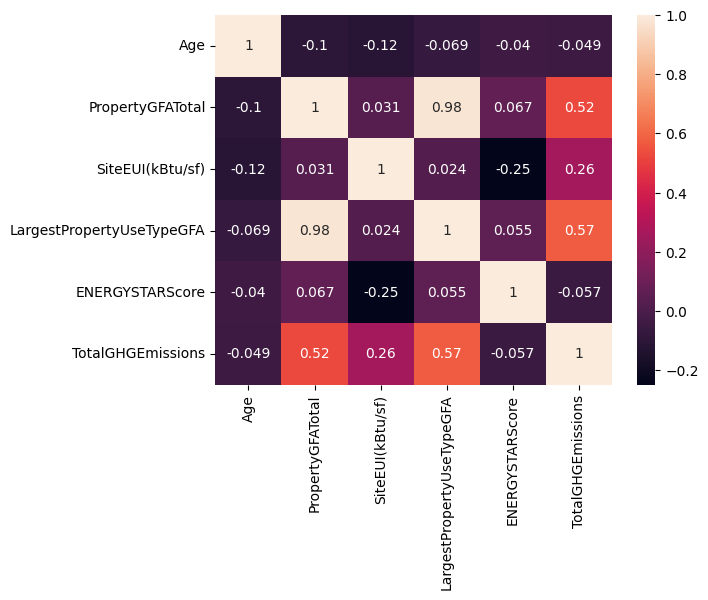

In [7]:
sns.heatmap(data[cols].corr(), annot = True)

In [8]:
X = data[['Age','NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking(%)',
        'PropertyGFABuilding(s)(%)','LargestPropertyUseTypeGFA','ENERGYSTARScore','EnergyStarNaN',
        'TotalGHGEmissions','GHGEmissionsIntensity',
        'PrimaryPropertyType_Distribution Center', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_Worship Facility','CouncilDistrictCode_1',
       'CouncilDistrictCode_2', 'CouncilDistrictCode_3',
       'CouncilDistrictCode_4', 'CouncilDistrictCode_5',
       'CouncilDistrictCode_6', 'CouncilDistrictCode_7']]

y = data['SiteEUI(kBtu/sf)']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
std_scale = StandardScaler()
std_scale.fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [11]:
dr = DummyRegressor(strategy='mean')
dr.fit(X_train, y_train)
y_pred = dr.predict(X_test)
baseline_error = mean_squared_error(y_test, y_pred, squared=False)
baseline_error

66.41613911261128

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr_error = mean_squared_error(y_test, y_pred, squared=False)
lr_error

31.485754602815597

In [13]:
def resultize(grid):

    res = pd.DataFrame(grid.cv_results_)
    res = res[['params', 'mean_test_RMSE', 'rank_test_RMSE', 'mean_test_MSE', 'rank_test_MSE', 'mean_test_MAE', 'rank_test_MAE', 'mean_test_R2', 'rank_test_R2']]
    res['mean_test_MSE'] = (-res[f'mean_test_MSE'])
    res['mean_test_RMSE'] = (-res[f'mean_test_RMSE'])
    res['mean_test_MAE'] = (-res[f'mean_test_MAE'])
    res.sort_values(by='rank_test_RMSE', inplace=True)
    return res

In [14]:
s = {'MSE': 'neg_mean_squared_error', 
      'RMSE': 'neg_root_mean_squared_error',
      'MAE': 'neg_mean_absolute_error',
      'R2': 'r2'}
score = 'RMSE'

In [15]:
params = {'alpha': np.logspace(-3, 10, 20)}
ridge = Ridge()
grid_ridge = GridSearchCV(ridge, params, cv=10, scoring = s , refit = score, n_jobs=-1)
grid_ridge.fit(X_train, y_train)
grid_ridge_best_params = grid_ridge.best_params_
resultize(grid_ridge).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
7,{'alpha': 61.58482110660267},47.237153,1,2557.659527,1,22.885875,1,0.581376,1
6,{'alpha': 12.742749857031347},47.263637,2,2558.219296,2,22.897288,2,0.579667,2
5,{'alpha': 2.636650898730358},47.678269,3,2592.037809,3,23.067698,3,0.568508,4
4,{'alpha': 0.545559478116852},47.984539,4,2619.524267,4,23.183940,4,0.560248,5
8,{'alpha': 297.63514416313194},48.056584,5,2623.131903,5,23.850290,9,0.569714,3


In [16]:
ridge = Ridge(**grid_ridge_best_params)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
ridge_error = mean_squared_error(y_test, y_pred, squared=False)
ridge_error

29.483727567866616

In [17]:
"""params = {'alpha': np.logspace(-3, 10, 200)}
grid_lasso = GridSearchCV(Lasso(), params, cv=10, scoring = s , refit = score, n_jobs=-1)
grid_lasso.fit(X_train, y_train)
grid_lasso_best_params = grid_lasso.best_params_
resultize(grid_lasso).head()"""

"params = {'alpha': np.logspace(-3, 10, 200)}\ngrid_lasso = GridSearchCV(Lasso(), params, cv=10, scoring = s , refit = score, n_jobs=-1)\ngrid_lasso.fit(X_train, y_train)\ngrid_lasso_best_params = grid_lasso.best_params_\nresultize(grid_lasso).head()"

In [18]:
grid_lasso_best_params = {'alpha': 0.748810385759003}

In [19]:
lasso = Lasso(**grid_lasso_best_params)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
lasso_error = mean_squared_error(y_test, y_pred, squared=False)
lasso_error

29.32839804520226

In [20]:
tt_ridge = TransformedTargetRegressor(regressor=Ridge(), 
                                    func=np.log1p, 
                                    inverse_func=np.expm1)
tt_ridge.fit(X_train, y_train)
y_pred = tt_ridge.predict(X_test)
tt_ridge_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ridge_error

55.761690146773475

In [21]:
params = {'regressor__alpha': np.logspace(0, 7, 100)}
grid_tt_ridge = GridSearchCV(tt_ridge, scoring=s, refit = score, param_grid=params, cv = 10)
grid_tt_ridge.fit(X_train, y_train)
grid_tt_ridge_best_params = grid_tt_ridge.best_params_
resultize(grid_tt_ridge).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
48,{'regressor__alpha': 2477.076355991709},66.366970,1,4800.422246,2,33.248071,7,0.184116,1
49,{'regressor__alpha': 2915.053062825176},66.635652,2,4780.651209,1,33.768984,9,0.173256,3
47,{'regressor__alpha': 2104.9041445120197},66.871051,3,5018.623181,5,32.774917,6,0.175140,2
50,{'regressor__alpha': 3430.4692863149157},67.312145,4,4852.106306,3,34.314991,10,0.153658,4
51,{'regressor__alpha': 4037.017258596554},68.156415,5,4961.526109,4,34.849988,11,0.130866,5


In [22]:
grid_tt_ridge_best_params = {'alpha': 2477.076355991709}

In [23]:
tt_ridge = TransformedTargetRegressor(
      regressor=Ridge(**grid_tt_ridge_best_params),
      func=np.log1p,
        inverse_func=np.expm1)
tt_ridge.fit(X_train, y_train)
y_pred = tt_ridge.predict(X_test)
tt_ridge_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ridge_error

54.44651418683198

In [24]:
tt_lasso = TransformedTargetRegressor(regressor=Lasso(),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
tt_lasso.fit(X_train, y_train)
y_pred = tt_lasso.predict(X_test)
tt_lasso_error = mean_squared_error(y_test, y_pred, squared=False)
tt_lasso_error

70.06120630201347

In [25]:
tt_lasso = TransformedTargetRegressor(regressor = Lasso(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__alpha': np.logspace(-1, 3, 30)}
grid_tt_lasso = GridSearchCV(tt_lasso, scoring=s, refit = score, param_grid=params, cv = 10)
grid_tt_lasso.fit(X_train, y_train)
grid_tt_lasso_best_params = grid_tt_lasso.best_params_
resultize(grid_tt_lasso).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
4,{'regressor__alpha': 0.3562247890262442},71.210779,1,5364.909800,1,37.848687,3,0.043492,2
3,{'regressor__alpha': 0.2592943797404667},71.265817,2,5695.767449,2,35.987127,1,0.053318,1
5,{'regressor__alpha': 0.4893900918477494},76.046461,3,6136.281200,3,40.594363,4,-0.086380,3
14,{'regressor__alpha': 8.531678524172806},76.222048,4,6157.204182,4,40.716995,5,-0.092899,4
27,{'regressor__alpha': 529.8316906283708},76.222048,4,6157.204182,4,40.716995,5,-0.092899,4


In [26]:
grid_tt_lasso_best_params = {'alpha': 0.3562247890262442}

In [27]:
tt_lasso = TransformedTargetRegressor(regressor = Lasso(**grid_tt_lasso_best_params),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_lasso.fit(X_train, y_train)
y_pred = tt_lasso.predict(X_test)
tt_lasso_error = mean_squared_error(y_test, y_pred, squared=False)
tt_lasso_error

63.61261657216235

In [28]:
svr = SVR()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
svr_error = mean_squared_error(y_test, y_pred, squared=False)
svr_error

61.22062310924783

In [29]:
'''params = {'kernel': ['sigmoid','rbf','poly'],
         'C': [0.1,1,100,1000],
         'degree': [1,2,3,4,5,6]}
grid_svr = GridSearchCV(SVR(), params, cv=10, scoring = s,
                        refit = score,  n_jobs=-1)
grid_svr.fit(X_train, y_train)
best_params_svr = grid_svr.best_params_
resultize(grid_svr).head()'''

"params = {'kernel': ['sigmoid','rbf','poly'],\n         'C': [0.1,1,100,1000],\n         'degree': [1,2,3,4,5,6]}\ngrid_svr = GridSearchCV(SVR(), params, cv=10, scoring = s,\n                        refit = score,  n_jobs=-1)\ngrid_svr.fit(X_train, y_train)\nbest_params_svr = grid_svr.best_params_\nresultize(grid_svr).head()"

In [30]:
grid_svr_best_params = {'C': 1000, 'degree': 1, 'kernel': 'poly'}

In [31]:
svr = SVR(**grid_svr_best_params)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
svr_error = mean_squared_error(y_test, y_pred, squared=False)
svr_error

27.292222308501405

In [32]:
tt_svr = SVR(**grid_svr_best_params)
tt_svr.fit(X_train, y_train)
y_pred = tt_svr.predict(X_test)
tt_svr_error = mean_squared_error(y_test, y_pred, squared=False)
tt_svr_error

27.292222308501405

In [33]:
tt_svr = TransformedTargetRegressor(regressor=SVR(),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
tt_svr.fit(X_train, y_train)
y_pred = tt_svr.predict(X_test)
tt_svr_error = mean_squared_error(y_test, y_pred, squared=False) 
tt_svr_error

35.2467586654863

In [34]:
'''tt_svr = TransformedTargetRegressor(regressor = SVR(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__C': [0.1,1,100,1000],
            'regressor__degree': [1,2,3,4,5,6],
            'regressor__kernel': ['sigmoid','rbf','poly']}
grid_tt_svr = GridSearchCV(tt_svr, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_svr.fit(X_train, y_train)
best_params_svr_tt = grid_tt_svr.best_params_
resultize(grid_tt_svr).head()'''

"tt_svr = TransformedTargetRegressor(regressor = SVR(),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__C': [0.1,1,100,1000],\n            'regressor__degree': [1,2,3,4,5,6],\n            'regressor__kernel': ['sigmoid','rbf','poly']}\ngrid_tt_svr = GridSearchCV(tt_svr, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_svr.fit(X_train, y_train)\nbest_params_svr_tt = grid_tt_svr.best_params_\nresultize(grid_tt_svr).head()"

In [35]:
grid_tt_svr_best_params = {'C': 1, 'degree': 1, 'kernel': 'rbf'}

In [36]:
tt_svr = TransformedTargetRegressor(regressor = SVR(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_svr.fit(X_train, y_train)
y_pred = tt_svr.predict(X_test)
tt_svr_error = mean_squared_error(y_test, y_pred, squared=False)
tt_svr_error

35.2467586654863

In [37]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_error = mean_squared_error(y_test, y_pred, squared=False)
rf_error

30.317272689606018

In [38]:
'''params = {'n_estimators': [10, 100, 1000],
            'max_depth': [1, 10, 100, 1000],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]}
grid_rf = GridSearchCV(RandomForestRegressor(), params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_params_rf = grid_rf.best_params_
resultize(grid_rf).head()'''
#1m16s

"params = {'n_estimators': [10, 100, 1000],\n            'max_depth': [1, 10, 100, 1000],\n            'min_samples_split': [2, 5, 10],\n            'min_samples_leaf': [1, 2, 4]}\ngrid_rf = GridSearchCV(RandomForestRegressor(), params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_rf.fit(X_train, y_train)\nbest_params_rf = grid_rf.best_params_\nresultize(grid_rf).head()"

In [39]:
best_params_rf = {'max_depth': 100,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

In [40]:
rf = RandomForestRegressor(**best_params_rf)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_error = mean_squared_error(y_test, y_pred, squared=False)
rf_error

30.47358676200463

In [41]:
tt_rf = TransformedTargetRegressor(regressor=RandomForestRegressor(),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
tt_rf.fit(X_train, y_train)
y_pred = tt_rf.predict(X_test)
tt_rf_error = mean_squared_error(y_test, y_pred, squared=False)
tt_rf_error

29.15032885081988

In [42]:
'''params = {'regressor__n_estimators': [10, 100, 1000],
            'regressor__max_depth': [1, 10, 100, 1000],
            'regressor__min_samples_split': [2, 5, 10],    
            'regressor__min_samples_leaf': [1, 2, 4]}
grid_tt_rf = GridSearchCV(tt_rf, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_rf.fit(X_train, y_train)
best_params_rf_tt = grid_tt_rf.best_params_
resultize(grid_tt_rf).head()'''
#1m17s

"params = {'regressor__n_estimators': [10, 100, 1000],\n            'regressor__max_depth': [1, 10, 100, 1000],\n            'regressor__min_samples_split': [2, 5, 10],    \n            'regressor__min_samples_leaf': [1, 2, 4]}\ngrid_tt_rf = GridSearchCV(tt_rf, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_rf.fit(X_train, y_train)\nbest_params_rf_tt = grid_tt_rf.best_params_\nresultize(grid_tt_rf).head()"

In [43]:
best_params_rf_tt = {'max_depth': 1000,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

In [44]:
tt_rf = TransformedTargetRegressor(regressor=RandomForestRegressor(**best_params_rf_tt),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
tt_rf.fit(X_train, y_train)
y_pred = tt_rf.predict(X_test)
tt_rf_error = mean_squared_error(y_test, y_pred, squared=False)
tt_rf_error

28.785170148389035

In [45]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
gb_error = mean_squared_error(y_test, y_pred, squared=False)
gb_error

29.629675424477455

In [46]:
'''params = {'loss': ['ls', 'lad', 'huber', 'quantile'],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [4, 6],
            'min_samples_leaf': [3, 5, 9, 17],
}
grid_gb = GridSearchCV(GradientBoostingRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_gb.fit(X_train, y_train)
best_params_gb = grid_gb.best_params_
resultize(grid_gb).head()'''
#30s

"params = {'loss': ['ls', 'lad', 'huber', 'quantile'],\n            'learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'max_depth': [4, 6],\n            'min_samples_leaf': [3, 5, 9, 17],\n}\ngrid_gb = GridSearchCV(GradientBoostingRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_gb.fit(X_train, y_train)\nbest_params_gb = grid_gb.best_params_\nresultize(grid_gb).head()"

In [47]:
best_params_gb = {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 3}

In [48]:
gb = GradientBoostingRegressor(**best_params_gb)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
gb_error = mean_squared_error(y_test, y_pred, squared=False)
gb_error

29.958828380993406

In [49]:
tt_gb = TransformedTargetRegressor(regressor=GradientBoostingRegressor(),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
tt_gb.fit(X_train, y_train)
y_pred = tt_gb.predict(X_test)
tt_gb_error = mean_squared_error(y_test, y_pred, squared=False)
tt_gb_error

26.549488662833966

In [50]:
'''params = {'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__max_depth': [4, 6],
            'regressor__min_samples_leaf': [3, 5, 9, 17]}
grid_tt_gb = GridSearchCV(tt_gb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_gb.fit(X_train, y_train)
best_params_gb_tt = grid_tt_gb.best_params_
resultize(grid_tt_gb).head()'''
#30s

"params = {'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],\n            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'regressor__max_depth': [4, 6],\n            'regressor__min_samples_leaf': [3, 5, 9, 17]}\ngrid_tt_gb = GridSearchCV(tt_gb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_gb.fit(X_train, y_train)\nbest_params_gb_tt = grid_tt_gb.best_params_\nresultize(grid_tt_gb).head()"

In [51]:
best_params_gb_tt = {'learning_rate': 0.1,
 'loss': 'huber',
 'max_depth': 4,
 'min_samples_leaf': 3}

In [52]:
tt_gb = TransformedTargetRegressor(regressor=GradientBoostingRegressor(**best_params_gb_tt),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
tt_gb.fit(X_train, y_train)
y_pred = tt_gb.predict(X_test)
tt_gb_error = mean_squared_error(y_test, y_pred, squared=False)
tt_gb_error

26.74539852902441

In [53]:
'''ad = AdaBoostRegressor()
params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'loss': ['linear', 'square', 'exponential'],
}
grid_ad = GridSearchCV(AdaBoostRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_ad.fit(X_train, y_train)
best_params_ad = grid_ad.best_params_
resultize(grid_ad).head()'''
#30s

"ad = AdaBoostRegressor()\nparams = {'n_estimators': [100, 200, 300, 400, 500],\n            'learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'loss': ['linear', 'square', 'exponential'],\n}\ngrid_ad = GridSearchCV(AdaBoostRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_ad.fit(X_train, y_train)\nbest_params_ad = grid_ad.best_params_\nresultize(grid_ad).head()"

In [54]:
best_params_ad = {'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 400}

In [55]:
ad = AdaBoostRegressor(**best_params_ad)
ad.fit(X_train, y_train)
y_pred = ad.predict(X_test)
ad_error = mean_squared_error(y_test, y_pred, squared=False)
ad_error

35.14190715721846

In [56]:
'''tt_ad = TransformedTargetRegressor(regressor=AdaBoostRegressor(),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__loss': ['linear', 'square', 'exponential'],
}
grid_tt_ad = GridSearchCV(tt_ad, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_ad.fit(X_train, y_train)
best_params_ad_tt = grid_tt_ad.best_params_
resultize(grid_tt_ad).head()'''
#30s

"tt_ad = TransformedTargetRegressor(regressor=AdaBoostRegressor(),\n                                    func=np.log1p,\n                                    inverse_func=np.expm1)\nparams = {'regressor__n_estimators': [100, 200, 300, 400, 500],\n            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'regressor__loss': ['linear', 'square', 'exponential'],\n}\ngrid_tt_ad = GridSearchCV(tt_ad, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_ad.fit(X_train, y_train)\nbest_params_ad_tt = grid_tt_ad.best_params_\nresultize(grid_tt_ad).head()"

In [57]:
best_params_ad_tt = {'learning_rate': 0.05,
      'loss': 'exponential',
      'n_estimators': 400}

In [58]:
tt_ad = TransformedTargetRegressor(regressor=AdaBoostRegressor(**best_params_ad_tt),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
tt_ad.fit(X_train, y_train)
y_pred = tt_ad.predict(X_test)
tt_ad_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ad_error

38.95190952868452

In [59]:
"""mlp = MLPRegressor()
params = {'hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'adam'],
}
grid_mlp = GridSearchCV(MLPRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_mlp.fit(X_train, y_train)
best_params_mlp = grid_mlp.best_params_
resultize(grid_mlp).head()"""
#1m30s

"mlp = MLPRegressor()\nparams = {'hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],\n            'activation': ['identity', 'logistic', 'tanh', 'relu'],\n            'solver': ['lbfgs', 'adam'],\n}\ngrid_mlp = GridSearchCV(MLPRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_mlp.fit(X_train, y_train)\nbest_params_mlp = grid_mlp.best_params_\nresultize(grid_mlp).head()"

In [60]:
best_params_mlp = {'activation': 'tanh', 'hidden_layer_sizes': (500,), 'solver': 'adam'}

In [61]:
mlp = MLPRegressor(**best_params_mlp)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
mlp_error = mean_squared_error(y_test, y_pred, squared=False)
mlp_error

30.24855776825452

In [62]:
"""tt_mlp = TransformedTargetRegressor(regressor=MLPRegressor(),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
params = {'regressor__hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'regressor__activation': ['identity', 'logistic', 'tanh', 'relu'],
            'regressor__solver': ['lbfgs', 'adam'],
}
grid_tt_mlp = GridSearchCV(tt_mlp, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_mlp.fit(X_train, y_train)
best_params_mlp_tt = grid_tt_mlp.best_params_
resultize(grid_tt_mlp).head()"""
#1m30s

"tt_mlp = TransformedTargetRegressor(regressor=MLPRegressor(),\n                                    func=np.log1p,\n                                    inverse_func=np.expm1)\nparams = {'regressor__hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],\n            'regressor__activation': ['identity', 'logistic', 'tanh', 'relu'],\n            'regressor__solver': ['lbfgs', 'adam'],\n}\ngrid_tt_mlp = GridSearchCV(tt_mlp, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_mlp.fit(X_train, y_train)\nbest_params_mlp_tt = grid_tt_mlp.best_params_\nresultize(grid_tt_mlp).head()"

In [63]:
best_params_mlp_tt = {'activation': 'logistic',
 'hidden_layer_sizes': (500,),
 'solver': 'lbfgs'}

In [64]:
tt_mlp = TransformedTargetRegressor(regressor=MLPRegressor(**best_params_mlp_tt),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
tt_mlp.fit(X_train, y_train)
y_pred = tt_mlp.predict(X_test)
tt_mlp_error = mean_squared_error(y_test, y_pred, squared=False)
tt_mlp_error

29.946506742995055

In [65]:
"""xgb = XGBRegressor()
params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [2, 3, 4, 5, 6]}
grid_xgb = GridSearchCV(XGBRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_params_xgb = grid_xgb.best_params_
resultize(grid_xgb).head()"""
#30s

"xgb = XGBRegressor()\nparams = {'n_estimators': [100, 200, 300, 400, 500],\n            'learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'max_depth': [2, 3, 4, 5, 6]}\ngrid_xgb = GridSearchCV(XGBRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_xgb.fit(X_train, y_train)\nbest_params_xgb = grid_xgb.best_params_\nresultize(grid_xgb).head()"

In [66]:
best_params_xgb = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}

In [67]:
xgb = XGBRegressor(**best_params_xgb)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
xgb_error = mean_squared_error(y_test, y_pred, squared=False)
xgb_error

29.900891868556062

In [68]:
tt_xgb = TransformedTargetRegressor(regressor=XGBRegressor(),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__max_depth': [2, 3, 4, 5, 6]}
grid_tt_xgb = GridSearchCV(tt_xgb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_xgb.fit(X_train, y_train)
best_params_xgb_tt = grid_tt_xgb.best_params_
resultize(grid_tt_xgb).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
49,"{'regressor__learning_rate': 0.05, 'regressor_...",40.938697,1,1928.806825,1,18.158610,14,0.687331,1
48,"{'regressor__learning_rate': 0.05, 'regressor_...",41.005851,2,1934.921964,2,18.073580,8,0.686061,2
47,"{'regressor__learning_rate': 0.05, 'regressor_...",41.027684,3,1937.638380,3,17.946655,4,0.685462,3
46,"{'regressor__learning_rate': 0.05, 'regressor_...",41.407191,4,1978.534511,7,17.905434,2,0.679546,7
13,"{'regressor__learning_rate': 0.1, 'regressor__...",41.454529,5,1967.797354,4,18.130369,13,0.682392,4


In [73]:
best_params_xgb_tt = {'learning_rate': 0.05,
 'max_depth': 6,
 'n_estimators': 500}

In [74]:
tt_xgb = TransformedTargetRegressor(regressor=XGBRegressor(**best_params_xgb_tt),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
tt_xgb.fit(X_train, y_train)
y_pred = tt_xgb.predict(X_test)
tt_xgb_error = mean_squared_error(y_test, y_pred, squared=False)
tt_xgb_error

26.6233151433355

In [77]:
errors = {'Baseline': baseline_error,
            'Linear Regression': lr_error,
            'Ridge': ridge_error,
            'Lasso': lasso_error,
            'Ridge_tt': tt_ridge_error,
            'Lasso_tt': tt_lasso_error,
            'SVR': svr_error,
            'SVR_tt': tt_svr_error,
            'Random Forest': rf_error,
            'Random Forest_tt': tt_rf_error,
            'Gradient Boosting': gb_error,
            'Gradient Boosting_tt': tt_gb_error,
            'AdaBoost': ad_error,
            'AdaBoost_tt': tt_ad_error,
            'MLP': mlp_error,
            'MLP_tt': tt_mlp_error,
            'XGBoost': xgb_error,
            'XGBoost_tt': tt_xgb_error}

In [78]:
#Classement des erreurs
errors = pd.DataFrame(errors.items(), columns=['Model', 'RMSE'])
errors = errors.sort_values(by='RMSE', ascending=True)
errors

,Model,RMSE
17,XGBoost_tt,26.623315
11,Gradient Boosting_tt,26.745399
6,SVR,27.292222
9,Random Forest_tt,28.785170
3,Lasso,29.328398
2,Ridge,29.483728
16,XGBoost,29.900892
15,MLP_tt,29.946507
10,Gradient Boosting,29.958828
14,MLP,30.248558


In [83]:
feat_imp_xgb_tt = pd.DataFrame({'Feature': X_train.columns, 'Importance': tt_xgb.regressor.feature_importances_})
feat_imp_xgb_tt = feat_imp_xgb_tt.sort_values(by='Importance', ascending=False)
feat_imp_xgb_tt

NotFittedError: need to call fit or load_model beforehand

In [85]:
feat_imp_gb_tt = pd.DataFrame({'importance': tt_gb.regressor_.feature_importances_})
feat_imp_gb_tt['feature'] = X_train.columns
feat_imp_gb_tt = feat_imp_gb_tt.sort_values(by='importance', ascending=False)
feat_imp_gb_tt

,importance,feature
10,0.601343,GHGEmissionsIntensity
9,0.113417,TotalGHGEmissions
7,0.073107,ENERGYSTARScore
23,0.030414,PrimaryPropertyType_Warehouse
5,0.024287,PropertyGFABuilding(s)(%)
0,0.021547,Age
13,0.021071,PrimaryPropertyType_K-12 School
4,0.020993,PropertyGFAParking(%)
6,0.017773,LargestPropertyUseTypeGFA
24,0.015494,PrimaryPropertyType_Worship Facility
